# Low Level Tensorflow API

This exercise introduces the low-level concepts and API of tensorflow.
You will learn the following concepts
  - basic tensorflow objects: tensor, operation, graph and session
  - automatic differentiation
  - multi-class classification (on MNIST)

In [1]:
from workshop_utils import *

## Numpy

I assume you are familiare with the **numpy** package.
If you execute numpy code the **numeric calculations** are done immediately.
So if we multiply a vector with a matrix we immediately get the result:

$$ \vec{y} = W \cdot \vec{x}$$

In [2]:
import numpy as np
x = np.array([[1.0, 2.0, 3.0]])
W = np.array([[4.0, 5.0], [6.0, 7.0], [8.0, 9.0]])
y = np.matmul(x, W)
NumpyToLatex(r"\vec{y} = x \cdot W = y")

### Brief NumPy Summary

A brief summary of the most basic concepts of numpy.

#### `np.ndarrays`
Numpy heavily builds on the `np.ndarray` class (**n-dimensional arrays**).
An `np.ndarray` consists of:
  - a data-type (**dtype**);
  - a dimension (**shape**);
  - and its stored values.

https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html

#### `np.ufunc`
Most numpy calculations can be understood in form of `np.ndarray` which are transformed by `np.ufunc`s (universal functions).

A `np.ufunc` operates on an `np.ndarray` in an element-by-element fashion
  * A fixed number of scalar inputs is mapped on a fixed number of scalar outputs
  * Supports vectorization
  * Usually implemented in C

https://docs.scipy.org/doc/numpy-1.14.0/reference/ufuncs.html

#### broadcasting

If you operate with a `np.ufunc` on `np.ndarrays` with different shapes, numpy will broadcast them for you.

 https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html

## Tensorflow

Tensorflow code looks at its core very similar to numpy, but instead of immediately calculating the result,
tensorflow builds a **symbolic representation** of your calculation called a **graph**.
This graph is then later executed on your CPU, GPU, or even distributed over several servers.

#### `np.ndarray` $\rightarrow$ `tf.Tensor`

Instead of np.ndarray objects, tensorflow builds on `tf.Tensor` objects.
A tensor represents an n-dimensional array with a **dtype**, a **shape** and a **name**.
But the shape can be partly unspecified (e.g. shape=[None, 3] would be a matrix with 3 columns and an unspecified number of rows). You input data, the output and the parameter of your neural networks, everything will be represented by a tf.Tensor.

https://www.tensorflow.org/programmers_guide/tensors

#### `np.ufunc` $\rightarrow$ `tf.Operation`

Every function you apply to a `tf.Tensor` will be represented as a `tf.Operation` in a `tf.Graph`.
A operation takes zero or more `tf.Tensor`s and outputs zero or more `tf.Tensor`s.

https://www.tensorflow.org/api_docs/python/tf/Operation

### `tf.Graph`

Let us build our first `tf.Graph`. Actually you don't have to create a `tf.Graph`, there is a default graph automatically created by tensorflow. We just wrap the numpy ndarrays defined above in `tf.Tensor` objects (here we use tf.constant). We apply the matrix multiplication operation to our tensors, and visualize the resulting graph.
**Remember**: We did not calculate anything yet, we just defined the calculation in a symbolic way!

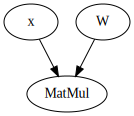

In [3]:
import tensorflow as tf
x_symbol = tf.constant(x, name='x')
W_symbol = tf.constant(W, name='W')
y_symbol = tf.matmul(x_symbol, W_symbol)
TensorflowGraphToDot(y_symbol)

<div class="alert alert-block alert-success">
You can think of the **nodes** of the graphs as the operations, and the **connections** of the graph as the **tensors flowing** in and out of the operations.

Hence the name: **tensorflow**
</div>

### Automatic Differentiation

Representing your calculation as a graph has many advantages. An important one is that we can perform symbolic calculations on the graph. For instance, tensorflow can automatically differentiate a graph with respect to one of its constituents.
The result will be another graph, which calculates the gradients.

For the training of arbitrary neural networks this is a huge advantage, because we only have to implement the forward pass of the neural network, and the necessary calculations for the backpropagation can be automatically generated by tensorflow!

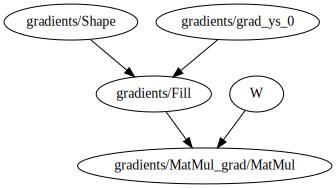

In [4]:
partial_derivative_symbol = tf.gradients(y_symbol, x_symbol)
TensorflowGraphToDot(partial_derivative_symbol)

### `tf.Session`

A `tf.Graph` can be executed on different devices (CPUs, GPUs, Distributed, ...).
Due to the graph structure you can also easily run different parts of the graph on different devices.
The `tf.Session` object is responsible for executing your graph accordingly.

In [5]:
session = tf.InteractiveSession()
session.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

You can execute a (part of a) graph by calling the **run** method of `tf.Session` with the `tf.Operation` (node of the graph) you want to calculate as the argument. This is the first time we actually calculate something in tensorflow! We get the same result as with our numpy code above.

In [6]:
session.run(y_symbol)

array([[40., 46.]])

### `tf.placeholder`

Instead of assigning to each symbol explicit values, we can put in some placeholders.
So we only have to define our graph once, and afterwards we can use it for many different inputs.

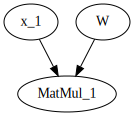

In [7]:
x_placeholder = tf.placeholder(dtype=tf.float64, shape=[1, 3], name='x')
y_symbol = tf.matmul(x_placeholder, W_symbol)
TensorflowGraphToDot(y_symbol)

Before executing the path, the placeholder is replaced by the value provided by the feed_dict argument.

In [8]:
session.run(y_symbol, feed_dict={x_placeholder: x})

array([[40., 46.]])

### Batch Processing

Instead of doing just one calculation, we can simultaneously do a whole **batch** of calculations.
Note that we leave the first dimension of our placeholder unspecified.

In [9]:
x = np.array([
    [1.0, 2.0, 3.0],
    [4.0, 5.0, 6.0],
    [7.0, 8.0, 8.0],
])

x_placeholder = tf.placeholder(dtype=tf.float64, shape=[None, 3], name='x')
y_symbol = tf.matmul(x_placeholder, W_symbol)
session.run(y_symbol, feed_dict={x_placeholder: x})

array([[ 40.,  46.],
       [ 94., 109.],
       [140., 163.]])

<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Modify the above code to calculate:

$$ y = \tanh(W \cdot x + b) $$

Execute the calculation with numpy and with tensorflow.

<h3>Question</h3>
Take a look at the partial derivative $\frac{\partial y}{\partial x}$.
Why does tensorflow still calculates the $\tanh$ term and not the derivative?
</div>

### Further Details

We won't go into further details here and instead focus on our first machine learning application.
For more information on the `tf.Graph` and `tf.Session` I refer you to:
 
https://www.tensorflow.org/programmers_guide/graphs

# MNIST

The MNIST database (Modified National Institute of Standards and Technology database) is a **dataset**
containing 60K training and 10K test images showing hadwritten digits with a resolution of 28x28.
Predicting the digit shown in each image is the "hello world" task of machine learning.

Tensorflow contains a convenience function, which automatically downloads and reads in the entire dataset.
The training dataset is further split into a 55K training and 5K validation set.

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Familiarize yourself with the dataset by executing the next line of code several times
</div>

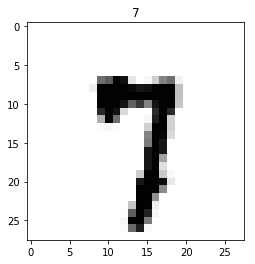

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
i = np.random.choice(55000)
plt.title(mnist.train.labels[i].argmax())
plt.imshow(mnist.train.images[i].reshape(28,28), cmap=plt.cm.Greys)

# Linear Model

In machine learning it is best practise to start with the simplest model to establish the overall procedure.

We implement a linear model $f$ with weights $W$:
$$ f: R^{784} \rightarrow [0, 1]^{10}$$

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W \cdot \vec{x}$$

Here we encounter a new concept in tensorflow: a `tf.Variable`. `tf.Variable`s are (of course) tensors which can be adjusted by operations. All free (learnable) parameters of your model are represented by a `tf.Variable`.

In [22]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([784, 10]))
logits = tf.matmul(x, W)
probabilities = tf.nn.softmax(logits)

### Loss-function

For **multi-class classification** one usually wants to minimize the **cross-entropy**.

$$ H(y,p) = - \sum_{i=1}^{10} y_i \log p_i $$

Keep in mind that we always operate on a batch of images (for instance $N = 100$ images per minimization-step).
Therefore our loss-function is the average cross-entropy.
$$ \mathcal{L} = \frac{1}{N} \sum_{j=1}^{N} H(y_j,p_j) $$

In [23]:
cross_entropy = -tf.reduce_sum(y * tf.log(probabilities + 0.001), axis=[1])
loss_function = tf.reduce_mean(cross_entropy)

### Optimization
We use a simple gradient-descent optimizer.

$$ \Delta W = - \eta \frac{\partial \mathcal{L}}{\partial W} \quad \quad \textrm{where} \quad \eta = 0.5 $$



In [24]:
minimize = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

### Training

Training in tensorflow means just running the **minimize** operation multiple times, here we run 1000 minimization steps. In each step we process a batch of 100 images, and adjusts the weights to minimize the mean cross-entropy of the batch.

In [25]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    session.run(minimize, feed_dict={x: batch_xs, y: batch_ys})

### Direct Evaluation

Finally we evaluate the linear model. We are interested in the **misclassification rate** of our model.
We evaluate the misclassification rate on the entire train and test dataset.

In [26]:
correct_prediction = tf.equal(tf.argmax(probabilities, 1), tf.argmax(y, 1))
misclassification_rate = 1.0 - tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Train", session.run(misclassification_rate, feed_dict={x: mnist.train.images, y: mnist.train.labels}))
print("Test ", session.run(misclassification_rate, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Train 0.08550906
Test  0.08469999


<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Add a bias $\vec{b}$ to the linear model

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W \cdot \vec{x} + \vec{b}$$

<h3>Question</h3>
What is the purpose of the bias?
</div>

# Shallow Neural Network

We established a baseline model. Next, we train our first neural network with tensorflow using the low-level API.
There are predefined convenience function for most
In machine learning it is best practise to start with the simplest model to establish the overall procedure.

We implement a neural network model $f$ with learnable weights $W_h$ and $W_o$ and biases $\vec{b}_h$ and $\vec{b}_o$:

$$ f: R^{784} \rightarrow [0, 1]^{10}$$

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W_o \cdot \tanh \left(W_h \cdot \vec{x} + \vec{b}_h \right) + \vec{b}_o$$

Note that we initialize the weights with random numbers.

In [27]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

W_h = tf.Variable(tf.random_normal([784, 20]))
b_h = tf.Variable(tf.zeros([20]))
hidden_activation = tf.tanh(tf.matmul(x, W_h) + b_h)

W_o = tf.Variable(tf.random_normal([20, 10]))
b_o = tf.Variable(tf.zeros([10]))
logits = tf.matmul(hidden_activation, W_o) + b_o

### Loss-function

Instead of calculating softmax and the cross-entropy ourselves, we use the `tf.nn.softmax_cross_entropy_with_logits_v2` function for this:
  1. The naiv softmax-cross-entropy implementation is numerically unstable if a probability is 0
  2. The native tensorflow function is optimized

In [28]:
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits))

In [29]:
minimize = tf.train.GradientDescentOptimizer(0.5).minimize(loss_function)

In [30]:
session = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    session.run(minimize, feed_dict={x: batch_xs, y: batch_ys})

In [31]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
misclassification_rate = 1.0 - tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Train", session.run(misclassification_rate, feed_dict={x: mnist.train.images, y: mnist.train.labels}))
print("Test ", session.run(misclassification_rate, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Train 0.07289094
Test  0.083599985


<div class="alert alert-block alert-info">
<h3>Exercise</h3>
Add an additional hidden layer to the model

$$ f(\vec{x}) = \underbrace{\frac{\exp \vec{l}}{\sum_{i=1}^{10} \exp l_i}}_{\mathrm{softmax}(l)} \quad \quad \textrm{where} \quad \vec{l} = W_o \cdot \tanh \left(W_{h_2} \cdot \tanh \left(W_{h_1} \cdot \vec{x} + \vec{b}_{h_1} \right) \vec{b}_{h_2} \right) + \vec{b}_o$$

<h3>Question</h3>
Why do we need to initialize the weights with random numbers?
</div>